# 🃏 Pai Tee Taek (ตีแตก): Strategy & Rules

This document outlines the specific rules, ranking systems, and strategic filters for **Pai Tee Taek**, designed for Monte Carlo simulation and risk analysis.

---

## 📋 Game Overview
* **Dealing:** Each player is dealt **4 cards**.
* **The Decider:** The dealer flips **1 center card** from the remaining deck.
* **Objective:** To win, a player must have at least one card in their hand that matches the **same suit** as the center card and holds a **higher rank**.

---

## ⚔️ Winning Conditions
Victory is determined by a two-tier verification:

1.  **Tier 1 (Suit Match):** You must hold a card of the same suit as the center card.
2.  **Tier 2 (Rank Match):** That matching card must have a higher rank than the center card.

> **Note:** If you have no matching suit, or the suit matches but the rank is lower, you lose the bet.

---

## 🔢 Special Ranking (The "2 Kills A" Rule)
This version of the game uses a non-standard hierarchy to allow for "trap" cards:

| Rank Priority | Card(s) | Result vs. Center Card |
| :--- | :--- | :--- |
| **Highest** | **A (Ace)** | Beats K, Q, J... down to 3. **Loses to 2.** |
| **The Counter** | **2** | **Beats A only.** Loses to every other number (3, 4, 5...). |
| **Standard** | **K, Q, J, 10 - 3** | Follows standard descending numerical order. |
| **Lowest** | **3** | The weakest card in this specific hierarchy. |

---

## 🌑 The Dark Rules (Risk Management)

### 1. The Discard (Fold)
* Players may look at their 4 cards and choose to "Fold" before the center card is revealed.
* **Penalty:** Pay a small predetermined fee instead of the full bet.

### 2. Blind Play (Dark Play)
* Players choose to bet **without looking** at their own cards.
* **Win:** Receive **100%** of the potential payout.
* **Loss:** Pay only **50%** of the bet amount.
* **Math Logic:** This strategy exploits the Expected Value ($EV$) where the loss is capped at $0.5x$ while the win remains $1.0x$.

---

## 💡 Play Criteria: "The 10+ Filter"
When playing "Light" (looking at cards), the player only commits to the bet if the following conditions are met:

1.  **Diversity:** The hand must contain at least **3 different suits**.
2.  **Quality:** Each of those unique suits must be represented by a card with a rank of **10 or higher**. (In this filter, 2 is treated as the lowest value).
3.  **Betting:** A flat bet of **500 units** is placed consistently when these conditions are met. Otherwise, the player folds.

---

## 🎯 Simulation Goals (Monte Carlo)

### Goal 1: Performance Comparison
Run a **100,000-round simulation** to compare:
* **Blind 100%:** Never looking at cards to capitalize on the 50% loss rule.
* **Strategic Look:** Using the "10+ Filter" and folding all other hands.
* **Result:** Determine which strategy yields the highest cumulative net profit.

### Goal 2: Optimization
Identify the optimal "Look" strategy by testing variations:
* Does lowering the rank threshold to 8+ or 9+ improve the total profit by increasing play frequency?
* What is the "sweet spot" between win rate and the number of games played?

---

# Goal 1

We want to compare between look or blind strategy which one is better (measure by profit)

### 1. Import Libraries

In [9]:
import random
import pandas as pd
import matplotlib.pyplot as plt

### 2. Some settings

In [5]:
ITERATIONS = 100000  # round to simulate
DISPLAY_LIMIT = 100  # round to display details
BET = 500            # bet amount each round
DARK_LOSS = 250      # loss amount on dark
LIGHT_LOSS = 500     # loss amount on light

### 3. Functions

In [12]:
def get_card_name(card):
    ranks = {11: 'J', 12: 'Q', 13: 'K', 14: 'A'}
    suits = {'C': '♣', 'D': '♦', 'H': '♥', 'S': '♠'}
    r, s = card
    name = str(ranks.get(r, r))
    return f"{name}{suits[s]}"

def is_win(hand, center):
    c_rank, c_suit = center
    for p_rank, p_suit in hand:
        if p_suit == c_suit:
            if p_rank == 2 and c_rank == 14: return True
            if p_rank > c_rank and not (p_rank == 14 and c_rank == 2): return True
    return False

def simulate_with_details():
    deck_base = [(r, s) for r in range(2, 15) for s in ['C', 'D', 'H', 'S']]
    results = []
    
    # Tracking balances for plotting
    dark_history = [0]
    light_history = [0]
    
    d_bal, l_bal = 0, 0
    
    for i in range(ITERATIONS):
        deck = deck_base[:]
        random.shuffle(deck)
        hand = deck[:4]
        center = deck[4]
        
        # Logic: Dark (Blind)
        win_dark = is_win(hand, center)
        d_bal += BET if win_dark else -DARK_LOSS
        dark_history.append(d_bal)
        
        # Logic: Light (Strategic Filter)
        high_card_suits = {c[1] for c in hand if c[0] >= 10}
        played_light = len(high_card_suits) >= 3
        
        res_light = "FOLD"
        if played_light:
            win_light = is_win(hand, center)
            l_bal += BET if win_light else -LIGHT_LOSS
            res_light = "WIN" if win_light else "LOSE"
        
        light_history.append(l_bal)
        
        # Collect first 100 rounds for the table
        if i < DISPLAY_LIMIT:
            results.append({
                "Round": i + 1,
                "Hand": " ".join([get_card_name(c) for c in hand]),
                "Center": get_card_name(center),
                "Dark_Result": "WIN" if win_dark else "LOSE",
                "Light_Action": "PLAY" if played_light else "FOLD",
                "Light_Result": res_light,
                "Dark_Bal": d_bal,
                "Light_Bal": l_bal
            })

    return pd.DataFrame(results), dark_history, light_history


### 4. Run a simulation

In [16]:
# --- Simulation Execution ---
df_details, dark_hist, light_hist = simulate_with_details()

# --- 1. Additional Statistics Calculation ---
# Dark Strategy Stats
d_wins_total = sum(1 for i in range(1, len(dark_hist)) if dark_hist[i] > dark_hist[i-1])

# Light Strategy Stats
l_plays_total = sum(1 for i in range(1, len(light_hist)) if light_hist[i] != light_hist[i-1])
l_wins_total = sum(1 for i in range(1, len(light_hist)) if light_hist[i] > light_hist[i-1])

# --- 2. Print Detailed Table (First 100 Rounds) ---
print(df_details.to_string(index=False))

# --- 3. Print Summary ---
print(f"\n" + "="*60)
print(f"📊 Simulation Summary: {ITERATIONS:,} Rounds")
print("-"*60)

# Dark Strategy Results
dark_win_rate = (d_wins_total / ITERATIONS) * 100
print(f"🌑 [Dark Strategy - Always Blind]")
print(f"   - Rounds Played: {ITERATIONS:,} (100.00%)")
print(f"   - Wins: {d_wins_total:,} | Win Rate: {dark_win_rate:.2f}%")
print(f"   - Net Profit: {dark_hist[-1]:,} THB")

print("-"*30)

# Light Strategy Results
l_play_freq = (l_plays_total / ITERATIONS) * 100
l_win_rate_actual = (l_wins_total / l_plays_total * 100) if l_plays_total > 0 else 0
print(f"💡 [Light Strategy - 10+ Filter]")
print(f"   - Rounds Played: {l_plays_total:,} (Played only {l_play_freq:.2f}% of total)")
print(f"   - Wins: {l_wins_total:,} | Win Rate (When Played): {l_win_rate_actual:.2f}%")
print(f"   - Net Profit: {light_hist[-1]:,} THB")

print("="*60)


 Round           Hand Center Dark_Result Light_Action Light_Result  Dark_Bal  Light_Bal
     1    A♦ 3♣ K♦ 5♣     8♠        LOSE         FOLD         FOLD      -250          0
     2 10♥ 10♠ 10♣ J♥     6♦        LOSE         PLAY         LOSE      -500       -500
     3    J♥ K♦ 4♦ Q♣     8♠        LOSE         PLAY         LOSE      -750      -1000
     4    8♣ K♠ K♦ 3♥     K♥        LOSE         FOLD         FOLD     -1000      -1000
     5    6♥ 9♠ 2♣ J♠     5♣        LOSE         FOLD         FOLD     -1250      -1000
     6   9♣ 10♣ 2♥ 5♣     5♠        LOSE         FOLD         FOLD     -1500      -1000
     7   10♣ 2♣ 3♠ 6♦     Q♦        LOSE         FOLD         FOLD     -1750      -1000
     8    A♥ 8♦ 4♦ K♦    10♠        LOSE         FOLD         FOLD     -2000      -1000
     9    K♥ Q♦ 6♦ 3♣     9♠        LOSE         FOLD         FOLD     -2250      -1000
    10    5♠ 3♠ Q♣ K♥     A♥        LOSE         FOLD         FOLD     -2500      -1000
    11    3♣ J♦ J♣ 7♠     Q♠    

### 5. Plot

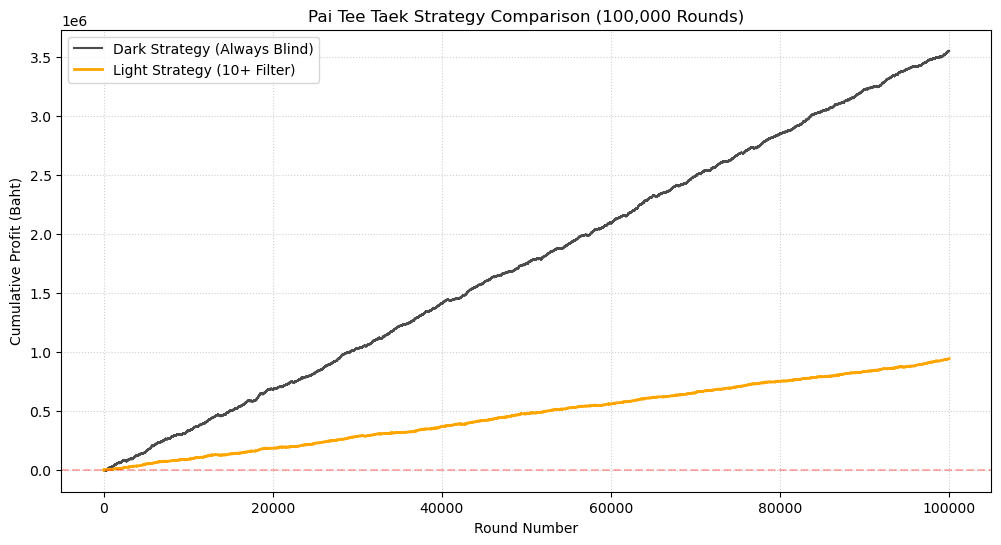

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(dark_hist, label='Dark Strategy (Always Blind)', color='black', alpha=0.7)
plt.plot(light_hist, label='Light Strategy (10+ Filter)', color='orange', linewidth=2)
plt.title(f'Pai Tee Taek Strategy Comparison ({ITERATIONS:,} Rounds)')
plt.xlabel('Round Number')
plt.ylabel('Cumulative Profit (Baht)')
plt.axhline(0, color='red', linestyle='--', alpha=0.3)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()